In [1]:
import os
import json
import random
from tensorflow import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()


def create_model(input_dim, num_classes, learning_rate):
    # Define hidden layer sizes
    hidden_layer1_neurons = int((2 / 3) * input_dim + num_classes)  # 2/3 of the input layer + size of the output layer
    hidden_layer2_neurons = input_dim  # matches the size of the Input Layer

    # Construct the model
    model = Sequential([
        InputLayer(input_shape=(input_dim,)),  # Defining Input Layer
        Dense(hidden_layer1_neurons, activation='relu'),  # Hidden Layer 1
        Dense(hidden_layer2_neurons, activation='relu'),  # Hidden Layer 2
        Dense(num_classes, activation='softmax')  # Output Layer
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model


class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_metrics, val_metrics, X_val_scaled, y_val):
        super(MetricsCallback, self).__init__()
        self.train_metrics = train_metrics
        self.val_metrics = val_metrics
        self.X_val_scaled = X_val_scaled
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.train_metrics['loss'].append(logs.get('loss'))
        self.train_metrics['accuracy'].append(logs.get('sparse_categorical_accuracy'))

        self.val_metrics['loss'].append(logs.get('val_loss'))
        self.val_metrics['accuracy'].append(logs.get('val_sparse_categorical_accuracy'))

        val_preds = np.argmax(self.model.predict(self.X_val_scaled, verbose=0), axis=1)
        val_labels = self.y_val

        self.val_metrics['precision'].append(precision_score(val_labels, val_preds, average='macro'))
        self.val_metrics['recall'].append(recall_score(val_labels, val_preds, average='macro'))
        self.val_metrics['f1_score'].append(f1_score(val_labels, val_preds, average='macro'))
        self.val_metrics['confusion_matrix'].append(confusion_matrix(val_labels, val_preds, normalize='true').tolist())


def main():    
    # Parameters
    CSV_FILE = "datasets/dataset_cl.parquet"
    EPOCHS = 100
    TRAIN_BATCH_SIZE = 32
    # TEST_BATCH_SIZE = 32 # The same as train if not set explicitly
    TEST_SIZE = 0.1667
    LEARNING_RATE = 0.001

    # Load and preprocess the dataset
    print("Loading data...")
    df = pd.read_parquet(CSV_FILE)

    # Extract features and target variable
    X = df.drop(columns=['application_name'])
    y = df['application_name']

    # Encode target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split the dataset
    print("Splitting data...")
    X_train, X_val, y_train, y_val = train_test_split(X, y_encoded,
                                                      test_size=TEST_SIZE,
                                                      # random_state=SEED,
                                                      stratify=y_encoded)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Get input dimension and number of classes
    input_dim = X_train_scaled.shape[1]
    num_classes = len(np.unique(y_encoded))

    # Initialize the model
    print("Initializing model...")
    model = create_model(input_dim, num_classes, LEARNING_RATE)

    # Initialize dictionaries to store metrics
    train_metrics = {'loss': [], 'accuracy': []}
    val_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'confusion_matrix': []}

    metrics_callback = MetricsCallback(train_metrics=train_metrics,
                                       val_metrics=val_metrics,
                                       X_val_scaled=X_val_scaled,
                                       y_val=y_val)

    # Train the model and collect metrics
    print("Starting training...")
    model.fit(X_train_scaled, y_train, epochs=EPOCHS, batch_size=TRAIN_BATCH_SIZE,
              validation_data=(X_val_scaled, y_val), callbacks=[metrics_callback], verbose=0)
    print("Training finished.")

    # Ensure directory exists
    os.makedirs("results", exist_ok=True)
    
    # Save the metrics to a JSON file
    with open("results/cl_results.json", 'w') as outfile:
        json.dump({"train_metrics": train_metrics, "val_metrics": val_metrics}, outfile, indent=4)

    print("Done.")

if __name__ == '__main__':
    main()

/Users/pekaradrian/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Loading data...
Splitting data...
Initializing model...
Starting training...
Training finished.
Done.


## Remove spaces and new line characters within the brackets for simpler data handling

## Plot the training versus validaiton accuracy and loss

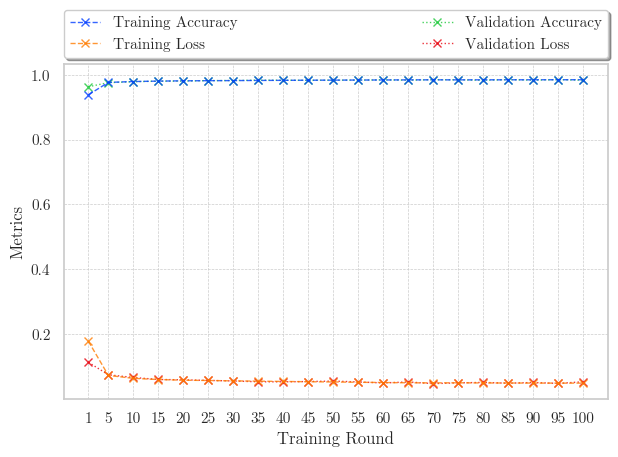

<Figure size 640x480 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
import json

def plot_metrics(rounds, metrics, filename):

    # Initialize list for lines and labels
    lines = []
    labels = []

    linestyles = ['--', '--', ':', ':']

    for i, (metric, values) in enumerate(metrics.items()):
        line, = plt.plot(rounds
                         , values
                         , marker='x'
                         , color=color_palette[i]
#                          , markersize=6
#                          , markeredgewidth=2
#                          , markerfacecolor='white'
#                          , markeredgecolor=color_palette[i]
                         , linestyle=linestyles[i % len(linestyles)] # adding linestyles
                         , alpha=0.8  # reducing alpha
                         , zorder=len(metrics)-i  # setting zorder
                         , linewidth=1.0
                        )
        lines.append(line)
        labels.append(f'{metric}')

    # Add title and labels
    plt.xlabel('Training Round')
    plt.ylabel('Metrics')

    # Add a legend
    plt.legend(lines, labels,
               bbox_to_anchor=(0., 1.02, 1., .102),
               loc='lower left',
               ncol=2,
               mode="expand",
               borderaxespad=0.,
               fancybox=True,
               shadow=True)

    plt.grid(linestyle='--', linewidth=0.5)

    # Set x ticks
    plt.xticks(rounds)

    # Show the plot
    plt.tight_layout()

    # Save the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

    # Clear the current plot to make ready for the next plot
    plt.clf()

# Set the font and color palette
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = '14'
color_palette = sns.color_palette("bright")

# Read the JSON file
with open('results/cl_results.json', 'r') as f:
    data = json.load(f)

# Extract metrics
train_metrics = data['train_metrics']
val_metrics = data['val_metrics']

metrics = {
"Training Accuracy"    : train_metrics['accuracy'],
"Training Loss"        : train_metrics['loss'],
"Validation Accuracy"  : val_metrics['accuracy'],
"Validation Loss"      : val_metrics['loss']
}

# Training rounds
n = 5

# Create a list of all rounds
all_rounds = np.arange(1, 101)

# Select specific rounds: 1, n, 2n, 3n, ..., 100
rounds = np.append(all_rounds[0], all_rounds[n-1::n])

# Update values to match new rounds
metrics = {key: np.append(values[0], values[n-1::n]) for key, values in metrics.items()}

# Ensure directory exists
os.makedirs("results/fig", exist_ok=True)

plot_metrics(rounds, metrics, 'results/fig/cl_acc_loss_all.png')

## Plot the validaiton accuracy along with the macro-averaged precision, recall, and f1-score

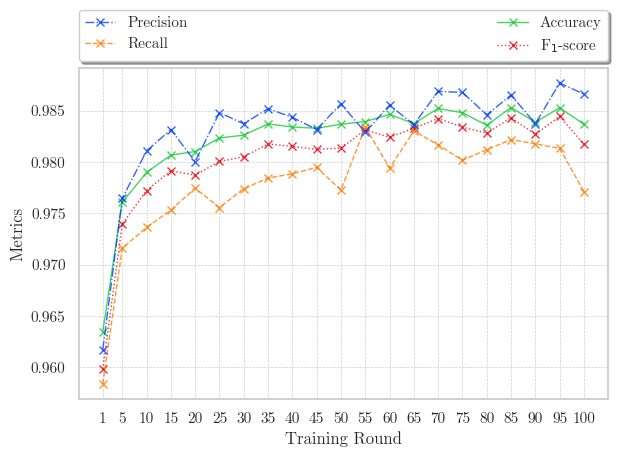

<Figure size 640x480 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D

def plot_metrics(rounds, metrics, filename):

    # Initialize list for lines and labels
    lines = []
    labels = []

    linestyles = ['-.', '--', '-', ':']
    for i, (metric, values) in enumerate(metrics.items()):
        line, = plt.plot(rounds
                         , values
                         , marker='x'
                         , color=color_palette[i]
#                          , markersize=6
#                          , markeredgewidth=2
#                          , markerfacecolor='white'
#                          , markeredgecolor=color_palette[i]
                         , linestyle=linestyles[i % len(linestyles)] # adding linestyles
                         , alpha=0.8  # reducing alpha
                         , zorder=len(metrics)-i  # setting zorder
                         , linewidth=1.0  # setting linewidth
                        )
        lines.append(line)
        if metric == "f1_score":
            labels.append('F$_1$-score')
        else:
            labels.append(metric.replace("_", "\_"))
#         labels.append(f'{metric}')

    # Add title and labels
    plt.xlabel('Training Round')
    plt.ylabel('Metrics')

    # Add a legend
    plt.legend(lines, labels,
               bbox_to_anchor=(0., 1.02, 1., .102),
               loc='lower left',
               ncol=2,
               mode="expand",
               borderaxespad=0.,
               fancybox=True,
               shadow=True)

    plt.grid(linestyle='--', linewidth=0.5)

    # Set x ticks
    plt.xticks(rounds)

    # Show the plot
    plt.tight_layout()

    # Save the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

    # Clear the current plot to make ready for the next plot
    plt.clf()

# Set the font and color palette
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = '14'
color_palette = sns.color_palette("bright")

# Read the JSON file
with open('results/cl_results.json', 'r') as f:
    data = json.load(f)

# Extract metrics
val_metrics = data['val_metrics']

# Client Data
metrics = {
        "Precision": val_metrics['precision'],
        "Recall": val_metrics['recall'],
        "Accuracy": val_metrics['accuracy'],
        "f1_score": val_metrics['f1_score']
}

# Training rounds
n = 5

# Create a list of all rounds
all_rounds = np.arange(1, 101)

# Select specific rounds: 1, n, 2n, 3n, ..., 100
rounds = np.append(all_rounds[0], all_rounds[n-1::n])

# Update values to match new rounds
metrics = {key: np.append(values[0], values[n-1::n]) for key, values in metrics.items()}

# Ensure directory exists
os.makedirs("results/fig", exist_ok=True)

plot_metrics(rounds, metrics, 'results/fig/cl_mpm_all.png')

## Plot the normalized confusion matrix

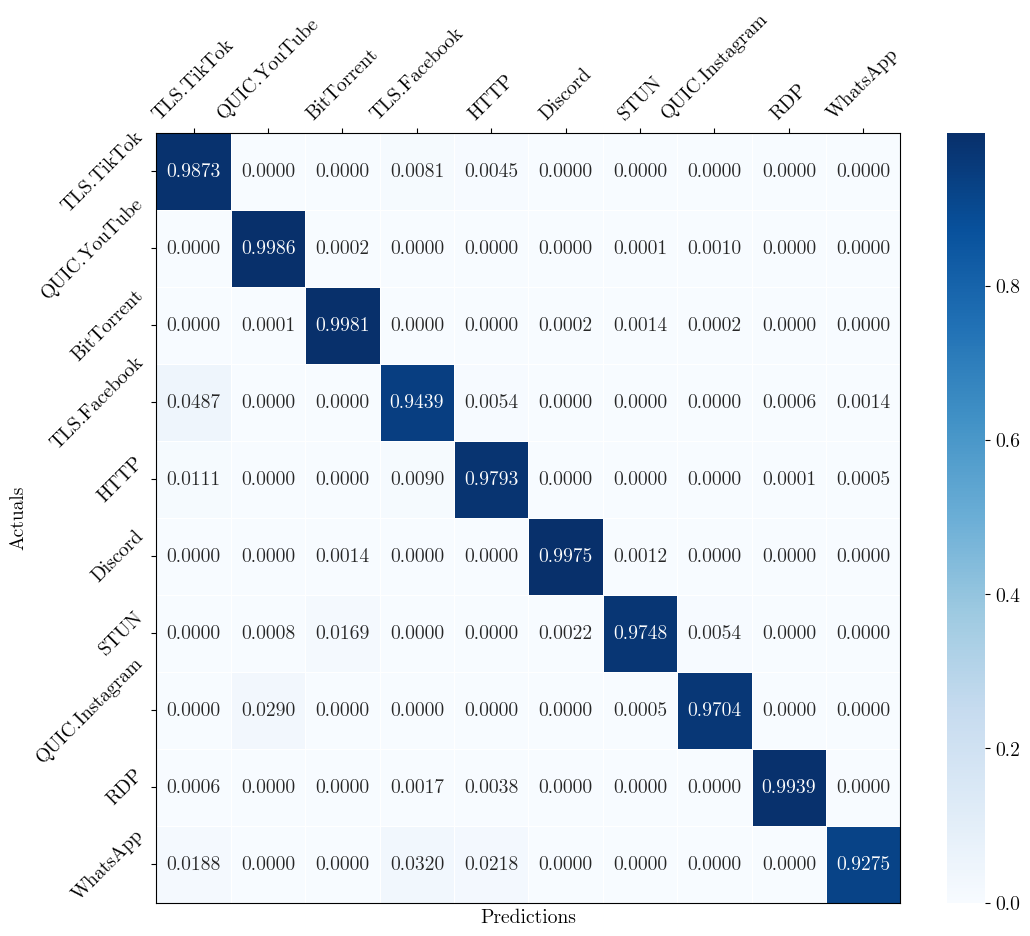

In [4]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the labels for our axes
labels =  ["TLS.TikTok", "QUIC.YouTube", "BitTorrent", "TLS.Facebook", "HTTP", 
           "Discord", "STUN", "QUIC.Instagram", "RDP", "WhatsApp"]

# Read the JSON file
with open('results/cl_results.json', 'r') as f:
    data = json.load(f)

# Extract metrics
val_metrics = data['val_metrics']

# Define the confusion matrix
cl_confusion = val_metrics['confusion_matrix'][-1]

FSIZE = 14

# Set the font family and size
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = FSIZE

cmap = sns.color_palette("Blues", as_cmap=True)

# Function to plot a confusion matrix
def plot_confusion_matrix(confusion_matrix, plot_name):
    fig, ax = plt.subplots(figsize=(12, 10))

    heatmap = sns.heatmap(confusion_matrix
                          , annot=True
                          , fmt=".4f"
                          , linewidths=.5
                          , ax=ax
                          , cmap=cmap
                          , cbar=True
                          , rasterized=False
                          )
    
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=FSIZE)

    for spine in ax.spines.values():
        spine.set(visible=True, lw=.8, edgecolor="black")

    # Set up axes
    ax.set_xticklabels(labels, rotation=45, ha='center', fontsize=FSIZE)  # Rotate the x-axis tick labels by 45 degrees
    ax.set_yticklabels(labels, rotation=45, ha='right', fontsize=FSIZE)  # Rotate the y-axis tick labels by 45 degrees
    ax.set_xlabel('Predictions', fontsize=FSIZE)
    ax.set_ylabel('Actuals', fontsize=FSIZE)
    
    # Move the x-axis tick labels to the top
    ax.xaxis.set_tick_params(labeltop=True, labelbottom=False)
    # ax.xaxis.set_tick_params(labeltop=False, labelbottom=False)

    # Move the x-axis ticks to the top
    ax.tick_params(axis='x', which='both', top=True, bottom=False)
    # ax.tick_params(axis='x', which='both', top=False, bottom=False)
    # ax.yaxis.set_tick_params(length=0)
    
    # Show the plot
    plt.savefig(plot_name, dpi=300, bbox_inches='tight')
    plt.show()

# Ensure directory exists
os.makedirs("results/fig", exist_ok=True)

plot_confusion_matrix(cl_confusion, "results/fig/cl_cm.png")